In [7]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


In [2]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def regplot_with_corr(
    data=None,
    x="x",
    y="y",
    cor_anonot=True,
    reg_anonot=True,
    annot_kws={
        "fontsize": 8,
        "xy": (0.95, 0.05),
        "ha": 'right',
        "va": 'bottom'
    },
    scatter_kws={
        's': 40,
        "alpha": 0.4
    },
    ax=None,
    **kwargs
):
    """

    Example:
    --------
    >>> Example usage
    >>> import pandas as pd
    >>> data = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [2, 3, 5, 7, 11]})
    >>> regplot_with_corr(data)
    >>> plt.show()
    """
    if ax is None:
        ax = plt.gca()
    if data is not None:
        data_x = data[x]
        data_y = data[y]
    else: 
        data_x = x
        data_y = y

    # Plot regression line and scatter plot
    sns.regplot(
        x=data_x,
        y=data_y,
        ci=None if len(np.unique(data_y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""
    if cor_anonot:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(data_x, data_y)
        # if np.isnan(correlation):
        #     correlation = 0
        # if np.isnan(p_value):
        #     p_value = 1
        p_str = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        annot_text += f"$r={correlation:.2f}$\n${p_str}$"

    if reg_anonot:
        # Calculate regression coefficients
        X = sm.add_constant(data_x)  # Adds a constant term to the predictor
        model = sm.OLS(data_y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    # Annotate the plot with correlation, p-value, intercept, and slope
    if annot_text != "":
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(
                boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'
            )
        )
    
    return ax


def az_summary(infdata=None, half_a=False, param_names_order=None, **kwargs):

    param_df = az.summary(infdata, kind="stats",
                            **kwargs).reset_index(names="param_name")
    # col_values = ['mean', 'sd', "hdi_3%", "hdi_97%"]
    col_values = list(param_df.columns[1:5])

    pattern = r'(.*)_subj\.(\d+)'

    param_df[['param',
                'subj_idx']] = param_df['param_name'].str.extract(pattern)
    # param_df['param'] = param_df['param'].apply(lambda x: f'${x}$')
    param_df = param_df.dropna(subset=['subj_idx'])
    param_df['subj_idx'] = param_df['subj_idx'].astype(int)

    if half_a:
        param_df.loc[param_df['param'] == 'a',
                        col_values] = param_df.loc[param_df['param'] == 'a',
                                                col_values] / 2

    param_df = param_df.pivot(
        index='subj_idx', columns='param', values=col_values
    )

    if param_names_order is not None:
        new_index = pd.MultiIndex.from_tuples(
            [
                (level_0, param) for level_0 in col_values
                for param in param_names_order
            ],
            names=[None, 'param']
        )
        param_df = param_df.reindex(columns=new_index)

    param_df.reset_index(inplace=True)
    param_df.columns.names = [None, None]

    return param_df

## Simulating Data

In [3]:
m2_infdata = az.from_netcdf("model_fitted/m2.nc")

In [4]:
data_cavanagh = m2_infdata.observed_data.to_dataframe().reset_index(drop=True)
df_ind_summary = data_cavanagh.groupby(['subj_idx','conf'])['rt'].describe().reset_index()
df_ind_summary = df_ind_summary.set_index('subj_idx').join(
    az_summary(m2_infdata)['mean'].reset_index(names=['subj_idx']).set_index('subj_idx')
    ).reset_index()
df_ind_summary.head()

,subj_idx,conf,count,mean,std,min,25%,50%,75%,max,a,t,"v_C(conf, Treatment('LC'))[T.HC]",v_Intercept,z
0,0,HC,147.0,-0.031857,1.941735,-3.83,-1.76000,0.827,1.705,3.86,2.050,0.699,-0.362,0.313,0.509
1,0,LC,151.0,0.301371,1.753550,-3.25,-1.37500,1.050,1.630,3.42,2.050,0.699,-0.362,0.313,0.509
2,1,HC,145.0,0.501200,1.523038,-3.21,-0.85600,0.949,1.500,3.31,1.984,0.541,-0.617,1.050,0.515
3,1,LC,153.0,0.891124,1.099653,-3.25,0.70000,1.050,1.410,3.11,1.984,0.541,-0.617,1.050,0.515
4,2,HC,146.0,0.195356,1.140053,-2.27,-0.93625,0.714,1.160,2.11,1.397,0.602,-0.655,0.966,0.513


In [6]:
group_param = az.summary(m2_infdata, var_names = ['~subj', '~std'], filter_vars= 'regex')

sim_data = pd.DataFrame()
for i,j in df_ind_summary.groupby(['subj_idx', 'conf']):
    if i[1] == "HC":
        v = j["v_Intercept"] + j["v_C(conf, Treatment('LC'))[T.HC]"]
    else:
        v = j["v_Intercept"]
    data, params = hddm.generate.gen_rand_data(
        {
            "v":v.iloc[0],
            "a":j["a"].iloc[0],
            "t":j["t"].iloc[0],
            "z":j["z"].iloc[0],
            "sv": group_param.loc["sv","mean"], 
            "st": group_param.loc["st","mean"], 
            "sz": group_param.loc["sz","mean"]
        },
        size=int(j["count"].iloc[0]),
        subjs=1,
    )
    data[['subj_idx','conf']] = i
    sim_data = pd.concat([sim_data, data], ignore_index=True, axis=0)
    sim_data.drop('condition',axis=1, inplace=True)

sim_data.head()

,rt,response,subj_idx,conf
0,2.408108,1.0,0,HC
1,3.111713,0.0,0,HC
2,1.615800,0.0,0,HC
3,0.992142,1.0,0,HC
4,0.766672,1.0,0,HC


## Parameter Recovery

### re-fitting model

In [ ]:
%time
# Model 2: regression model (varying intercept and slope)
m2_recovery = hddm.HDDMRegressor(
  sim_data, "v ~ 1 + C(conf, Treatment('LC'))", 
  include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'], 
  group_only_regressors=False, 
  keep_regressor_trace=True)
# Set progress_bar=False to hide the program's progress bar to simplify the output
m2_recovery, m2_recovery_infdata = run_sampling(m2_recovery, model_name="m2_recovery", progress_bar=False)

No model attribute --> setting up standard HDDM
Set model to full_ddm


116533.41s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
116533.64s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
116533.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
116534.09s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_s

hddm sampling elpased time:  18647.841 s
hddm sampling elpased time:  18718.206 s
hddm sampling elpased time:  18811.975 s
hddm sampling elpased time:  19013.322 s
hddm sampling elpased time:  19063.358 s
Start converting to InferenceData...
CPU times: user 1min 7s, sys: 2.72 s, total: 1min 10s
Wall time: 5h 17min 46s


### plot

In [9]:
m2_recovery_infdata = az.from_netcdf("model_fitted/m2_recovery.nc")

### group level

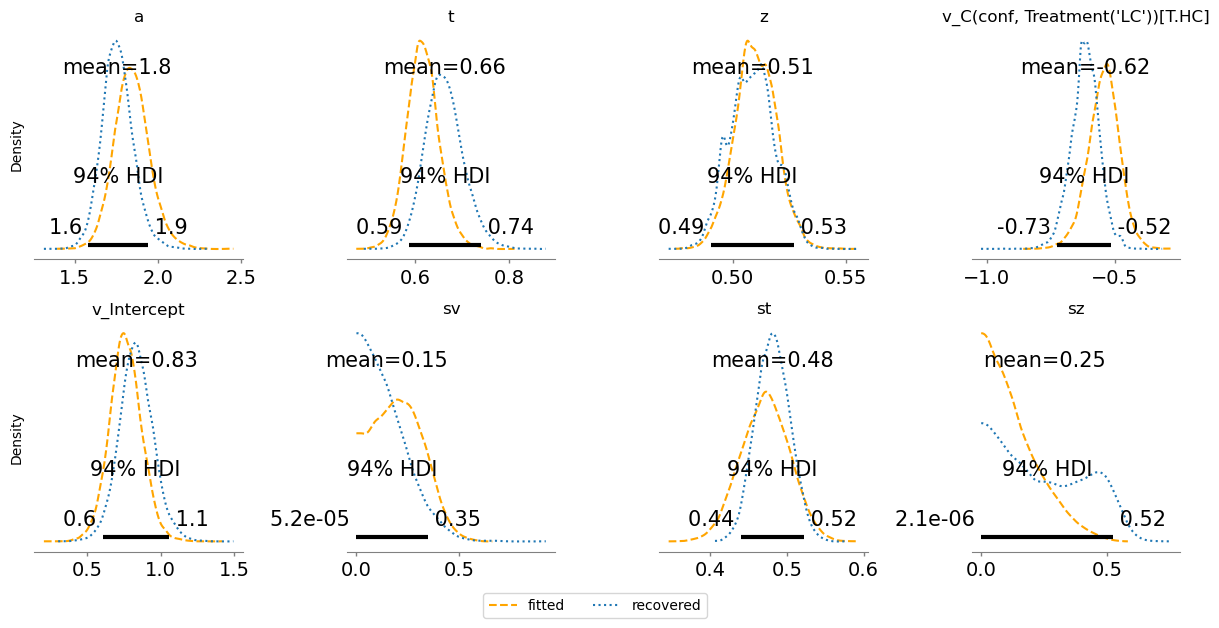

In [9]:
param_list = [
    'a', 't', 'z', "v_C(conf, Treatment('LC'))[T.HC]", 'v_Intercept', 'sv', 'st',
    'sz'
]
n_params = len(param_list)
n_cols = 4
figsize = (12, 6)

n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

for i, param in enumerate(param_list):
    az.plot_posterior(
        m2_infdata.posterior[param],
        ax=ax[i],
        color="orange",
        linestyle="dashed",
        # alpha=0.5,
        label="fitted",
        hdi_prob='hide',
        point_estimate=None
    )
    az.plot_posterior(
        m2_recovery_infdata.posterior[param],
        ax=ax[i],
        linestyle="dotted",
        # alpha=0.5, 
        label="recovered",
    )
    ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
    ax[i].set_title(param)
    if i == 0:
        handles, labels = ax[0].get_legend_handles_labels()
    if ax[i].get_legend():
        ax[i].legend_.remove()  # Remove legend from each subplot

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout()
plt.show()

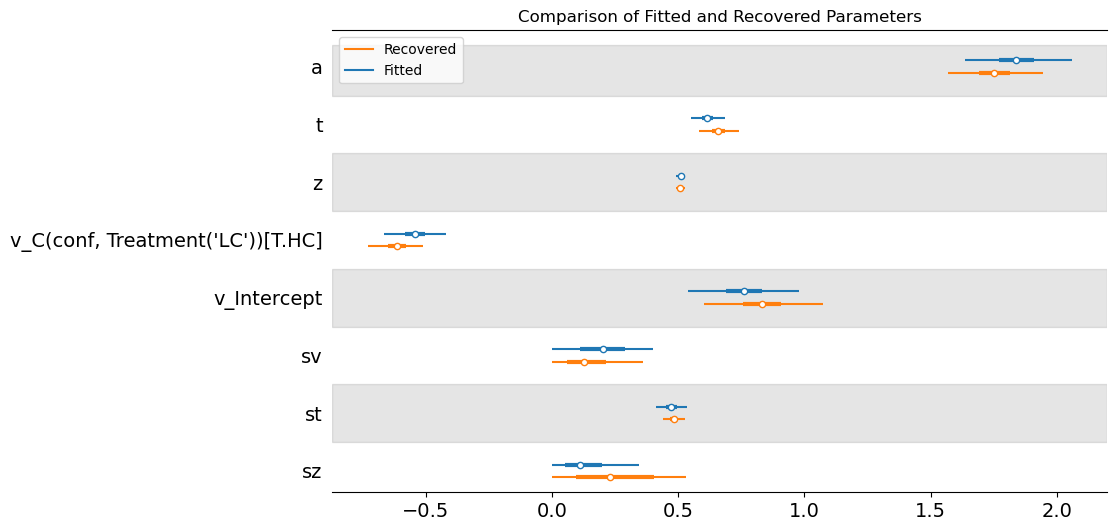

In [10]:
param_list = ['a', 't', 'z', "v_C(conf, Treatment('LC'))[T.HC]", 'v_Intercept', 'sv', 'st', 'sz']

# forest plot
fig, ax = plt.subplots(figsize=(10, 6))

az.plot_forest([m2_infdata, m2_recovery_infdata],
               model_names=["Fitted", "Recovered"],
               var_names=param_list,
               combined=True,
               ridgeplot_alpha=0.5,
               hdi_prob=0.95,
               ax=ax)

ax.set_title("Comparison of Fitted and Recovered Parameters")
plt.show()

### individual level

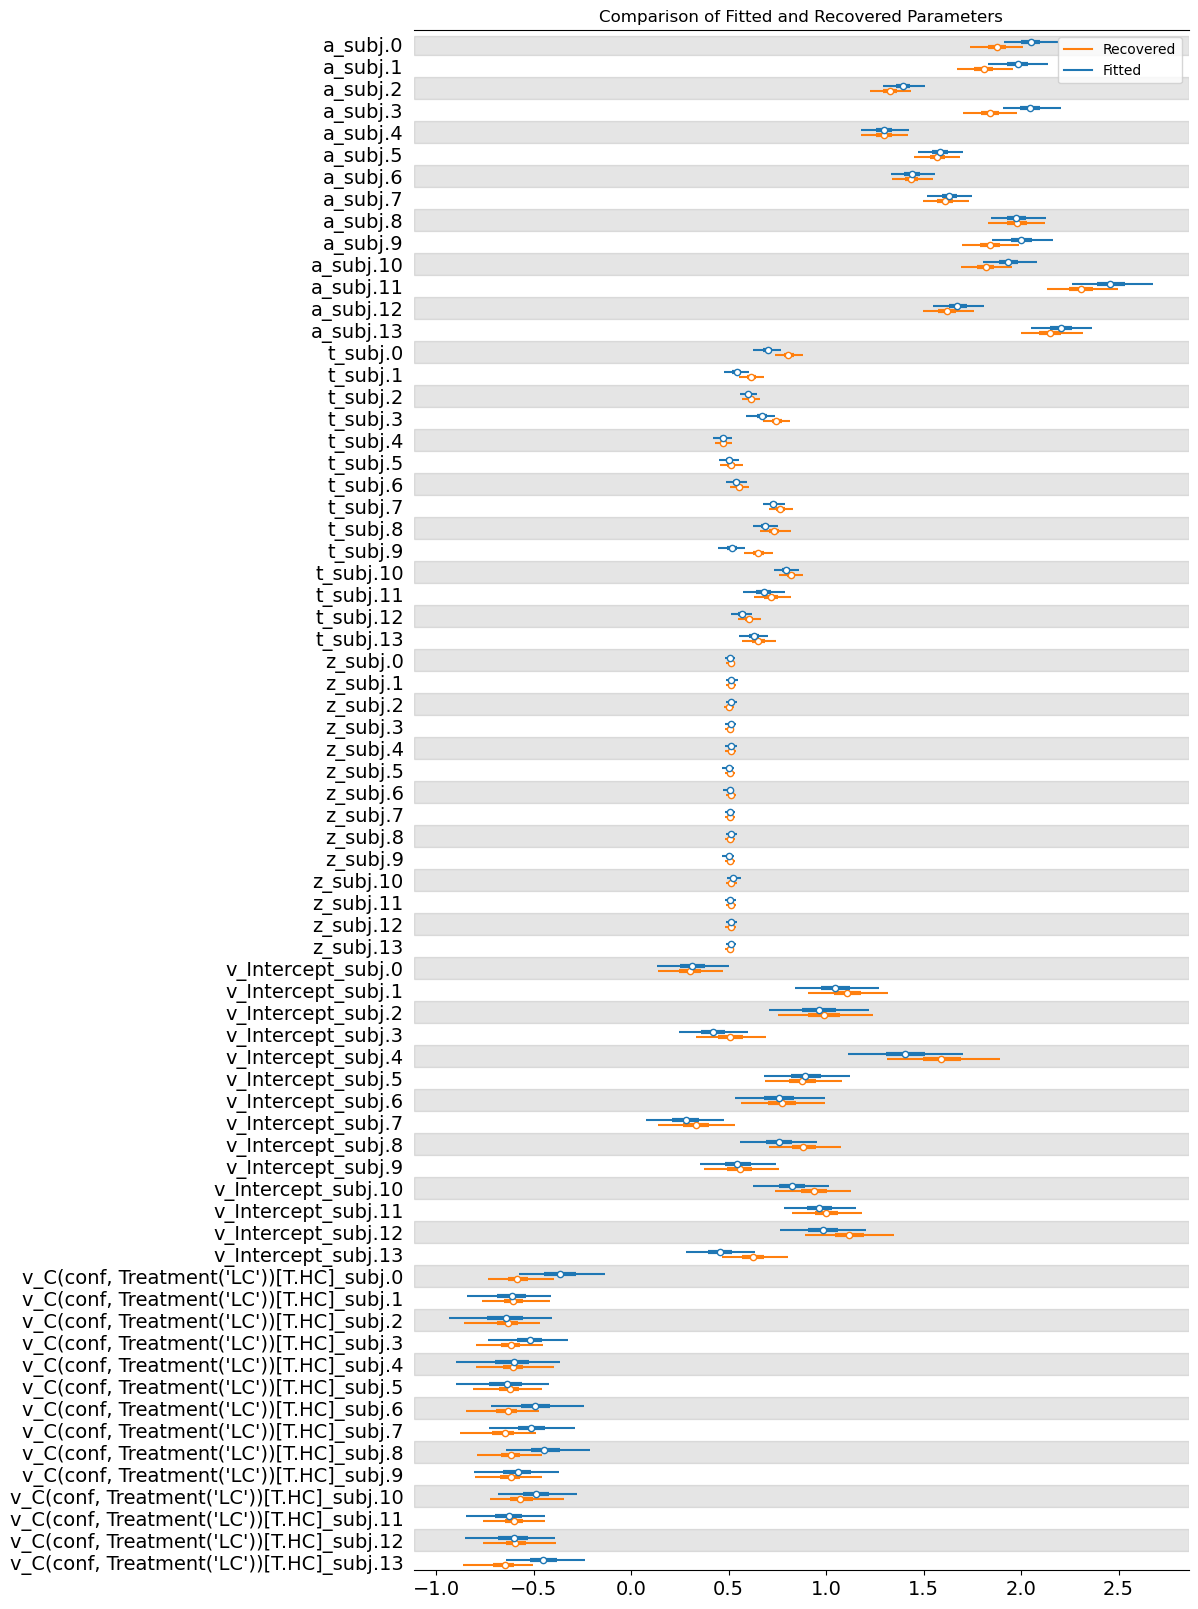

In [11]:
param_list = [param for param in m2_infdata.posterior.data_vars if 'subj' in param and 'std' not in param]

# forest plot
fig, ax = plt.subplots(figsize=(10, 20))

az.plot_forest([m2_infdata, m2_recovery_infdata],
               model_names=["Fitted", "Recovered"],
               var_names = param_list, 
               combined=True,
               ridgeplot_alpha=0.5,
               hdi_prob=0.95,
               ax=ax)

ax.set_title("Comparison of Fitted and Recovered Parameters")
plt.show()

In [12]:
param_fitted = az_summary(m2_infdata)["mean"]
param_recovery = az_summary(m2_recovery_infdata)["mean"]

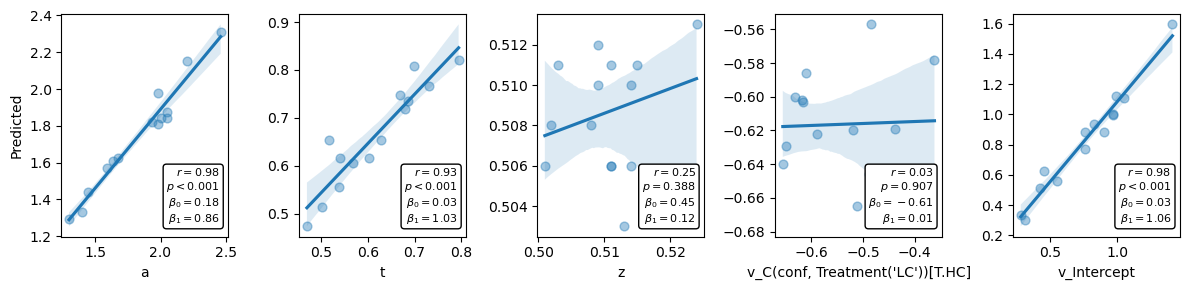

In [14]:
param_list = ['a', 't', 'z', "v_C(conf, Treatment('LC'))[T.HC]", 'v_Intercept']

f, ax = plt.subplots(ncols=len(param_list), figsize=(12, 3))

# regplot_with_corr
for i, param in enumerate(param_list):
    regplot_with_corr(x=param_fitted[param], y=param_recovery[param], ax=ax[i])
    if i == 0:
        ax[i].set_ylabel('Predicted')
    else:
        ax[i].set_ylabel('')

plt.tight_layout()
plt.show()